In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
import math

In [8]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', index_col='Date')

In [9]:
dataset.index = pd.to_datetime(dataset.index.values)
# dataset = dataset.resample('W').mean()

In [10]:
dataset.head()

,Temp
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [11]:
dataset.tail()

,Temp
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [12]:
dataset.shape

(3650, 1)

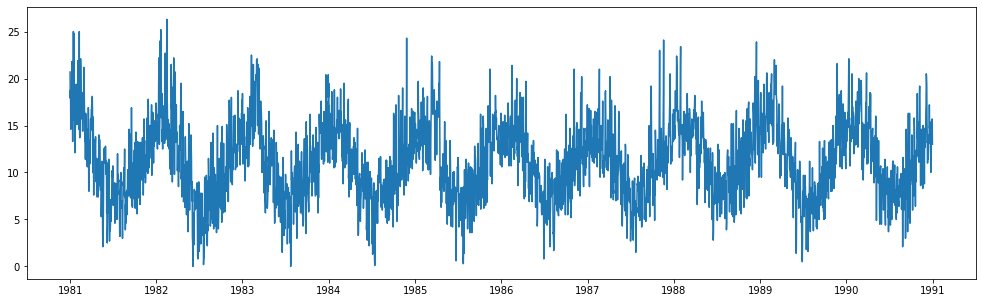

In [13]:
plt.figure(figsize=(17,5))
sns.lineplot(x=dataset.index.values, y=dataset.Temp.values)
plt.show()

In [14]:
def split_dataset(data):
    train_len = math.ceil(data.shape[0]*.8)
    test_len = math.ceil(data.shape[0] - train_len)
    train, test = data[:train_len], data[train_len:]
    train = np.array(np.split(train, train_len/10))
    test = np.array(np.split(test, test_len/10))
    return train, test

def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [15]:
train, test = split_dataset(dataset.values)
print(train.shape)
print(test.shape)


train_x, train_y = to_supervised(train, 10, 10)
print(train_x[0])
print(train_y[0])

(292, 10, 1)
(73, 10, 1)
[[20.7]
 [17.9]
 [18.8]
 [14.6]
 [15.8]
 [15.8]
 [15.8]
 [17.4]
 [21.8]
 [20. ]]
[16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8 17.7 15.5]


In [99]:

# define parameters
verbose, epochs, batch_size = 1, 50, 30
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

Epoch 1/50
78/78 [==============================] - 6s 41ms/step - loss: 25.7840 - val_loss: 9.0466
Epoch 2/50
78/78 [==============================] - 3s 37ms/step - loss: 9.3751 - val_loss: 8.8552
Epoch 3/50
78/78 [==============================] - 3s 37ms/step - loss: 9.2456 - val_loss: 8.8791
Epoch 4/50
78/78 [==============================] - 3s 37ms/step - loss: 9.0792 - val_loss: 8.9054
Epoch 5/50
78/78 [==============================] - 3s 37ms/step - loss: 9.2054 - val_loss: 8.8819
Epoch 6/50
78/78 [==============================] - 3s 38ms/step - loss: 9.1807 - val_loss: 8.6471
Epoch 7/50
78/78 [==============================] - 3s 38ms/step - loss: 9.0564 - val_loss: 8.8810
Epoch 8/50
78/78 [==============================] - 3s 41ms/step - loss: 8.9371 - val_loss: 8.4848
Epoch 9/50
78/78 [==============================] - 3s 45ms/step - loss: 9.0053 - val_loss: 8.9112
Epoch 10/50
78/78 [==============================] - 3s 44ms/step - loss: 9.1691 - val_loss: 8.4686
Epoch 11

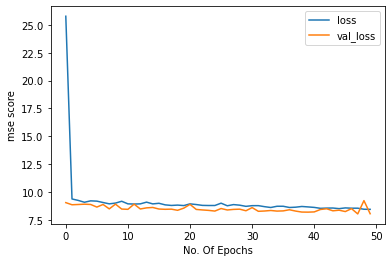

In [100]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")
plt.show()

In [34]:
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

history = [x for x in train]
predictions = list()
n_input = 10

for i in range(len(test)):
    yhat_sequence = forecast(model, history, n_input)
    predictions.append(yhat_sequence)
    history.append(test[i, :])

In [63]:
predictions = np.array(predictions)
y_pred = predictions.flatten()
y_test = test.flatten()

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_lstm)

2.732498882652417


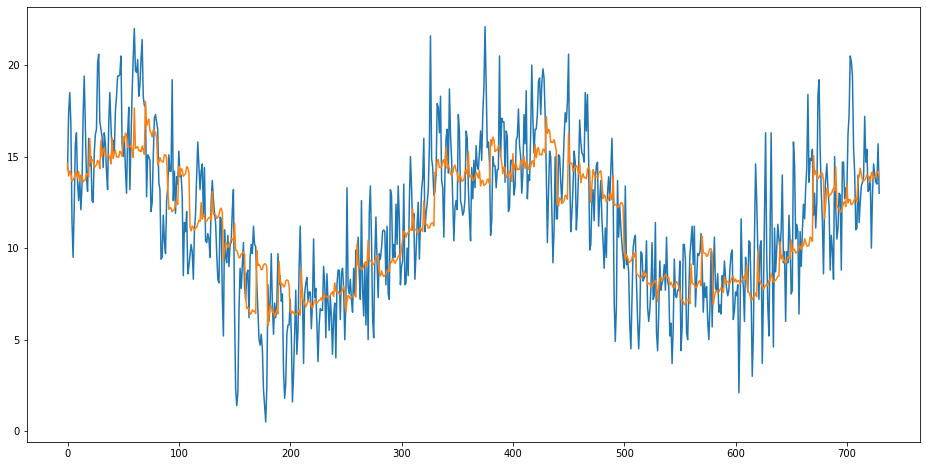

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.show()

In [92]:
next_pred = y_pred

curr_predictor = test[-1].reshape(1,10,1)
curr_prediction = model.predict(curr_predictor)
for x in curr_prediction:
    next_pred = np.append(next_pred, x)

In [93]:
next_pred.shape

(740,)

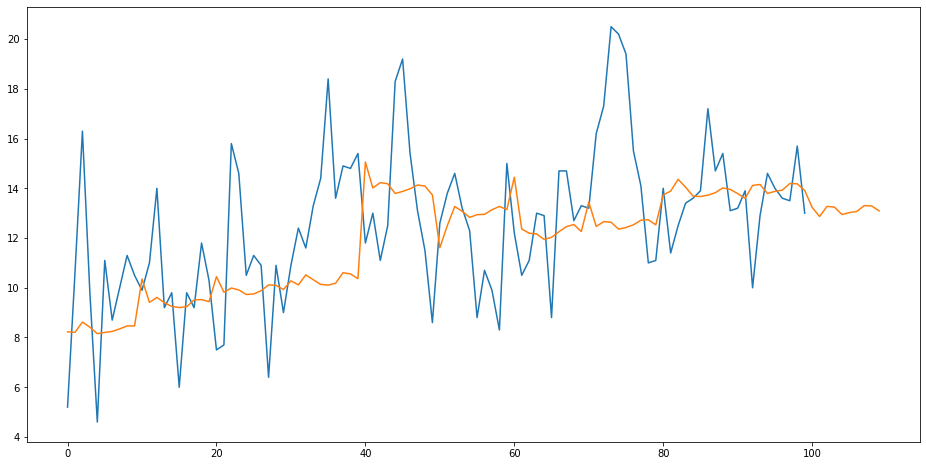

In [98]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[-100:], label='true')
plt.plot(next_pred[-110:], label='predicted')
plt.show()